# 04. Networks Assignment

# NYC Wi-Fi Hotspot Network Analysis: Euclidean vs Network Distance


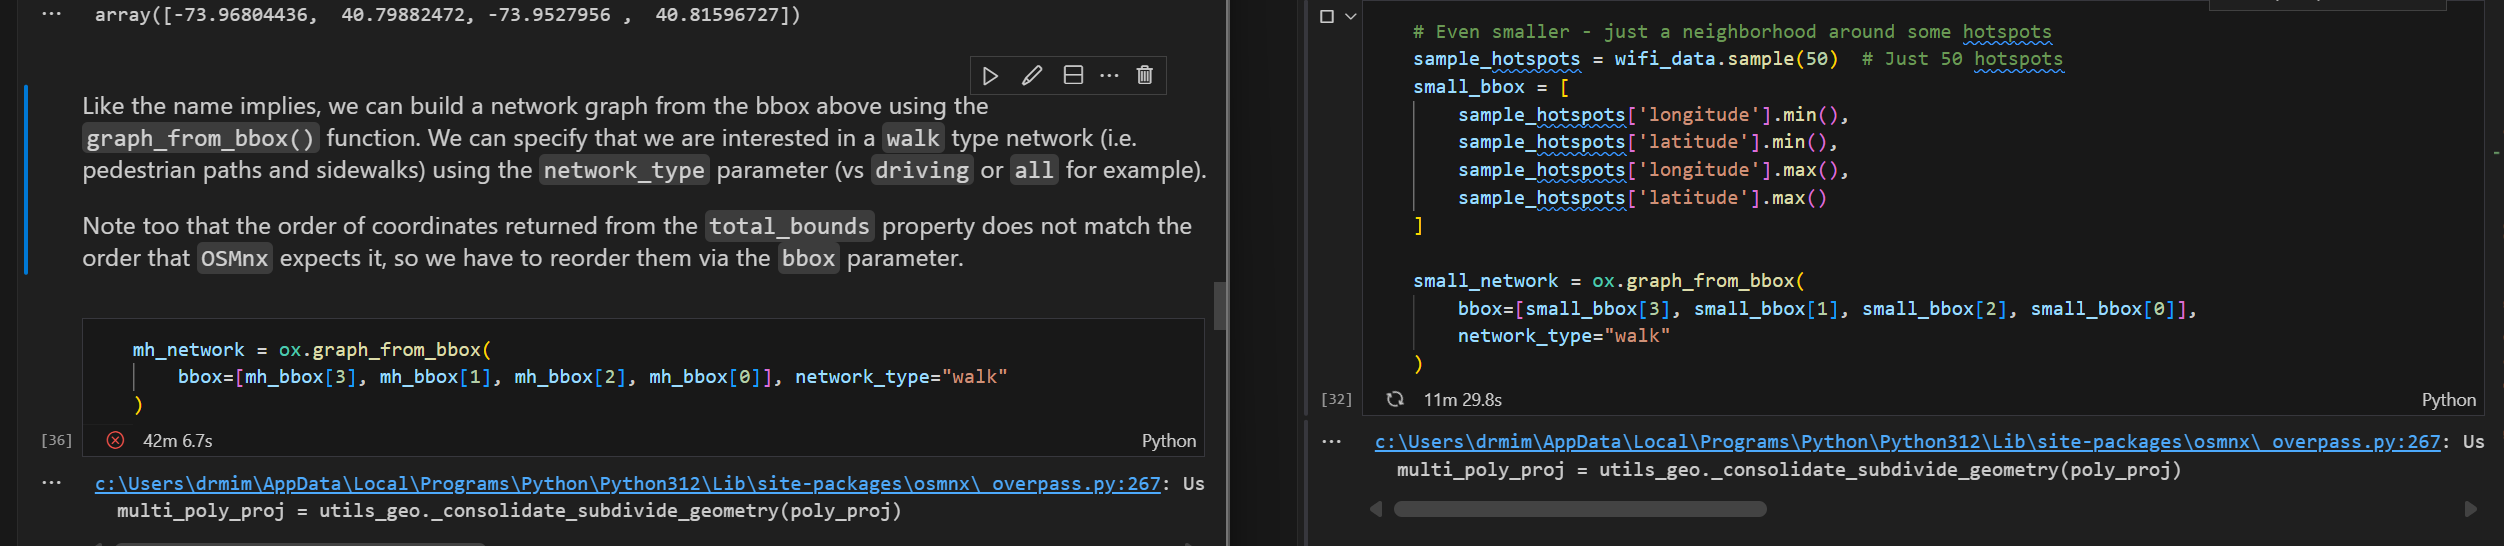

*I encountered huge wait times which hindered my ability to work with the data even after trying to reduce the range. It might be because I was using apartment wifi?

## Research Statement

This analysis examines NYC's public Wi-Fi infrastructure by building networks of Wi-Fi hotspots and comparing straight-line distance versus actual network connectivity. We explore how these different distance measures affect real-world accessibility and digital equity.

**Research Questions:**
1. How does network connectivity differ from simple geographic proximity?
2. What are the practical differences between Euclidean and network distances for Wi-Fi access?
3. Which hotspots are most critical for overall network connectivity?

## Network Definition

**Nodes**: Individual Wi-Fi hotspots (with lat/lon coordinates)
**Edges**: Connections between hotspots within 400m walking distance
**Distance Types**: 
- Euclidean: Straight-line distance
- Network: Shortest path through connected hotspots

## Experiential Differences

### Euclidean Distance ("As the Crow Flies")
- Direct line between two points
- Ignores barriers like rivers, highways, buildings
- Unrealistic for actual travel

### Network Distance (Real Accessibility)  
- Shortest path through connected network
- Reflects walking constraints and urban barriers
- Shows actual accessibility patterns

**Key Differences:**
- Geographic barriers create major detours
- Street grids force indirect routes
- Transit connections change effective distances
- Provider coverage affects seamless connectivity

## Methodology

1. **Network Construction**: Connect hotspots within 400m of each other
2. **Distance Calculation**: Compare Euclidean vs. shortest network path
3. **Network Analysis**: Calculate centrality measures to find critical nodes
4. **Visualization**: Maps showing connectivity and distance comparisons

## Expected Findings

- Network distances will be significantly longer than Euclidean distances
- Bridge/tunnel crossings will show largest discrepancies
- Some hotspots will be critical connection points despite average location
- Outer boroughs may have accessibility gaps despite decent coverage

This analysis reveals how network structure affects real-world digital infrastructure accessibility beyond simple geographic measures.

## Import libraries

In [2]:
# Test script to check if all required packages are installed
print("Testing package imports...")

try:
    import geopandas as gpd
    print("✓ geopandas imported successfully")
except ImportError as e:
    print(f"✗ geopandas import failed: {e}")

try:
    import numpy as np
    print("✓ numpy imported successfully")
except ImportError as e:
    print(f"✗ numpy import failed: {e}")

try:
    import matplotlib.pyplot as plt
    print("✓ matplotlib imported successfully")
except ImportError as e:
    print(f"✗ matplotlib import failed: {e}")

try:
    from shapely.geometry import LineString, MultiLineString, Point, Polygon
    print("✓ shapely imported successfully")
except ImportError as e:
    print(f"✗ shapely import failed: {e}")

try:
    import pandas as pd
    print("✓ pandas imported successfully")
except ImportError as e:
    print(f"✗ pandas import failed: {e}")

try:
    import requests
    print("✓ requests imported successfully")
except ImportError as e:
    print(f"✗ requests import failed: {e}")

try:
    import networkx as nx
    print("✓ networkx imported successfully")
except ImportError as e:
    print(f"✗ networkx import failed: {e}")

try:
    import osmnx as ox
    print("✓ osmnx imported successfully")
except ImportError as e:
    print(f"✗ osmnx import failed: {e}")

try:
    import h3
    print("✓ h3 imported successfully")
except ImportError as e:
    print(f"✗ h3 import failed: {e}")

try:
    import libpysal as lps
    print("✓ libpysal imported successfully")
except ImportError as e:
    print(f"✗ libpysal import failed: {e}")

print("\nImport test complete!")


import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

Testing package imports...
✓ geopandas imported successfully
✓ numpy imported successfully
✓ matplotlib imported successfully
✓ shapely imported successfully
✓ pandas imported successfully
✓ requests imported successfully
✓ networkx imported successfully
✓ osmnx imported successfully
✓ h3 imported successfully
✓ libpysal imported successfully

Import test complete!


## Apply to a real-world example


The toy problem above was a fine way to explore this concept, so now let's apply it to real-world networks. We will use an API endpoint hosted through NYCOpenData to find restaurants in Morningside Heights.

There are a couple of things to keep in mind about the following API request. First is the request itself: we use the popular `requests` library to perform a `GET` request (there are many types of requests, read more [here](https://requests.readthedocs.io/en/latest/user/quickstart/#make-a-request)) on the API endpoint listed at the resource URL. 


We can see on the open data portal's website that each dataset has an `Actions` dropdown, and within that there's an `API` option:

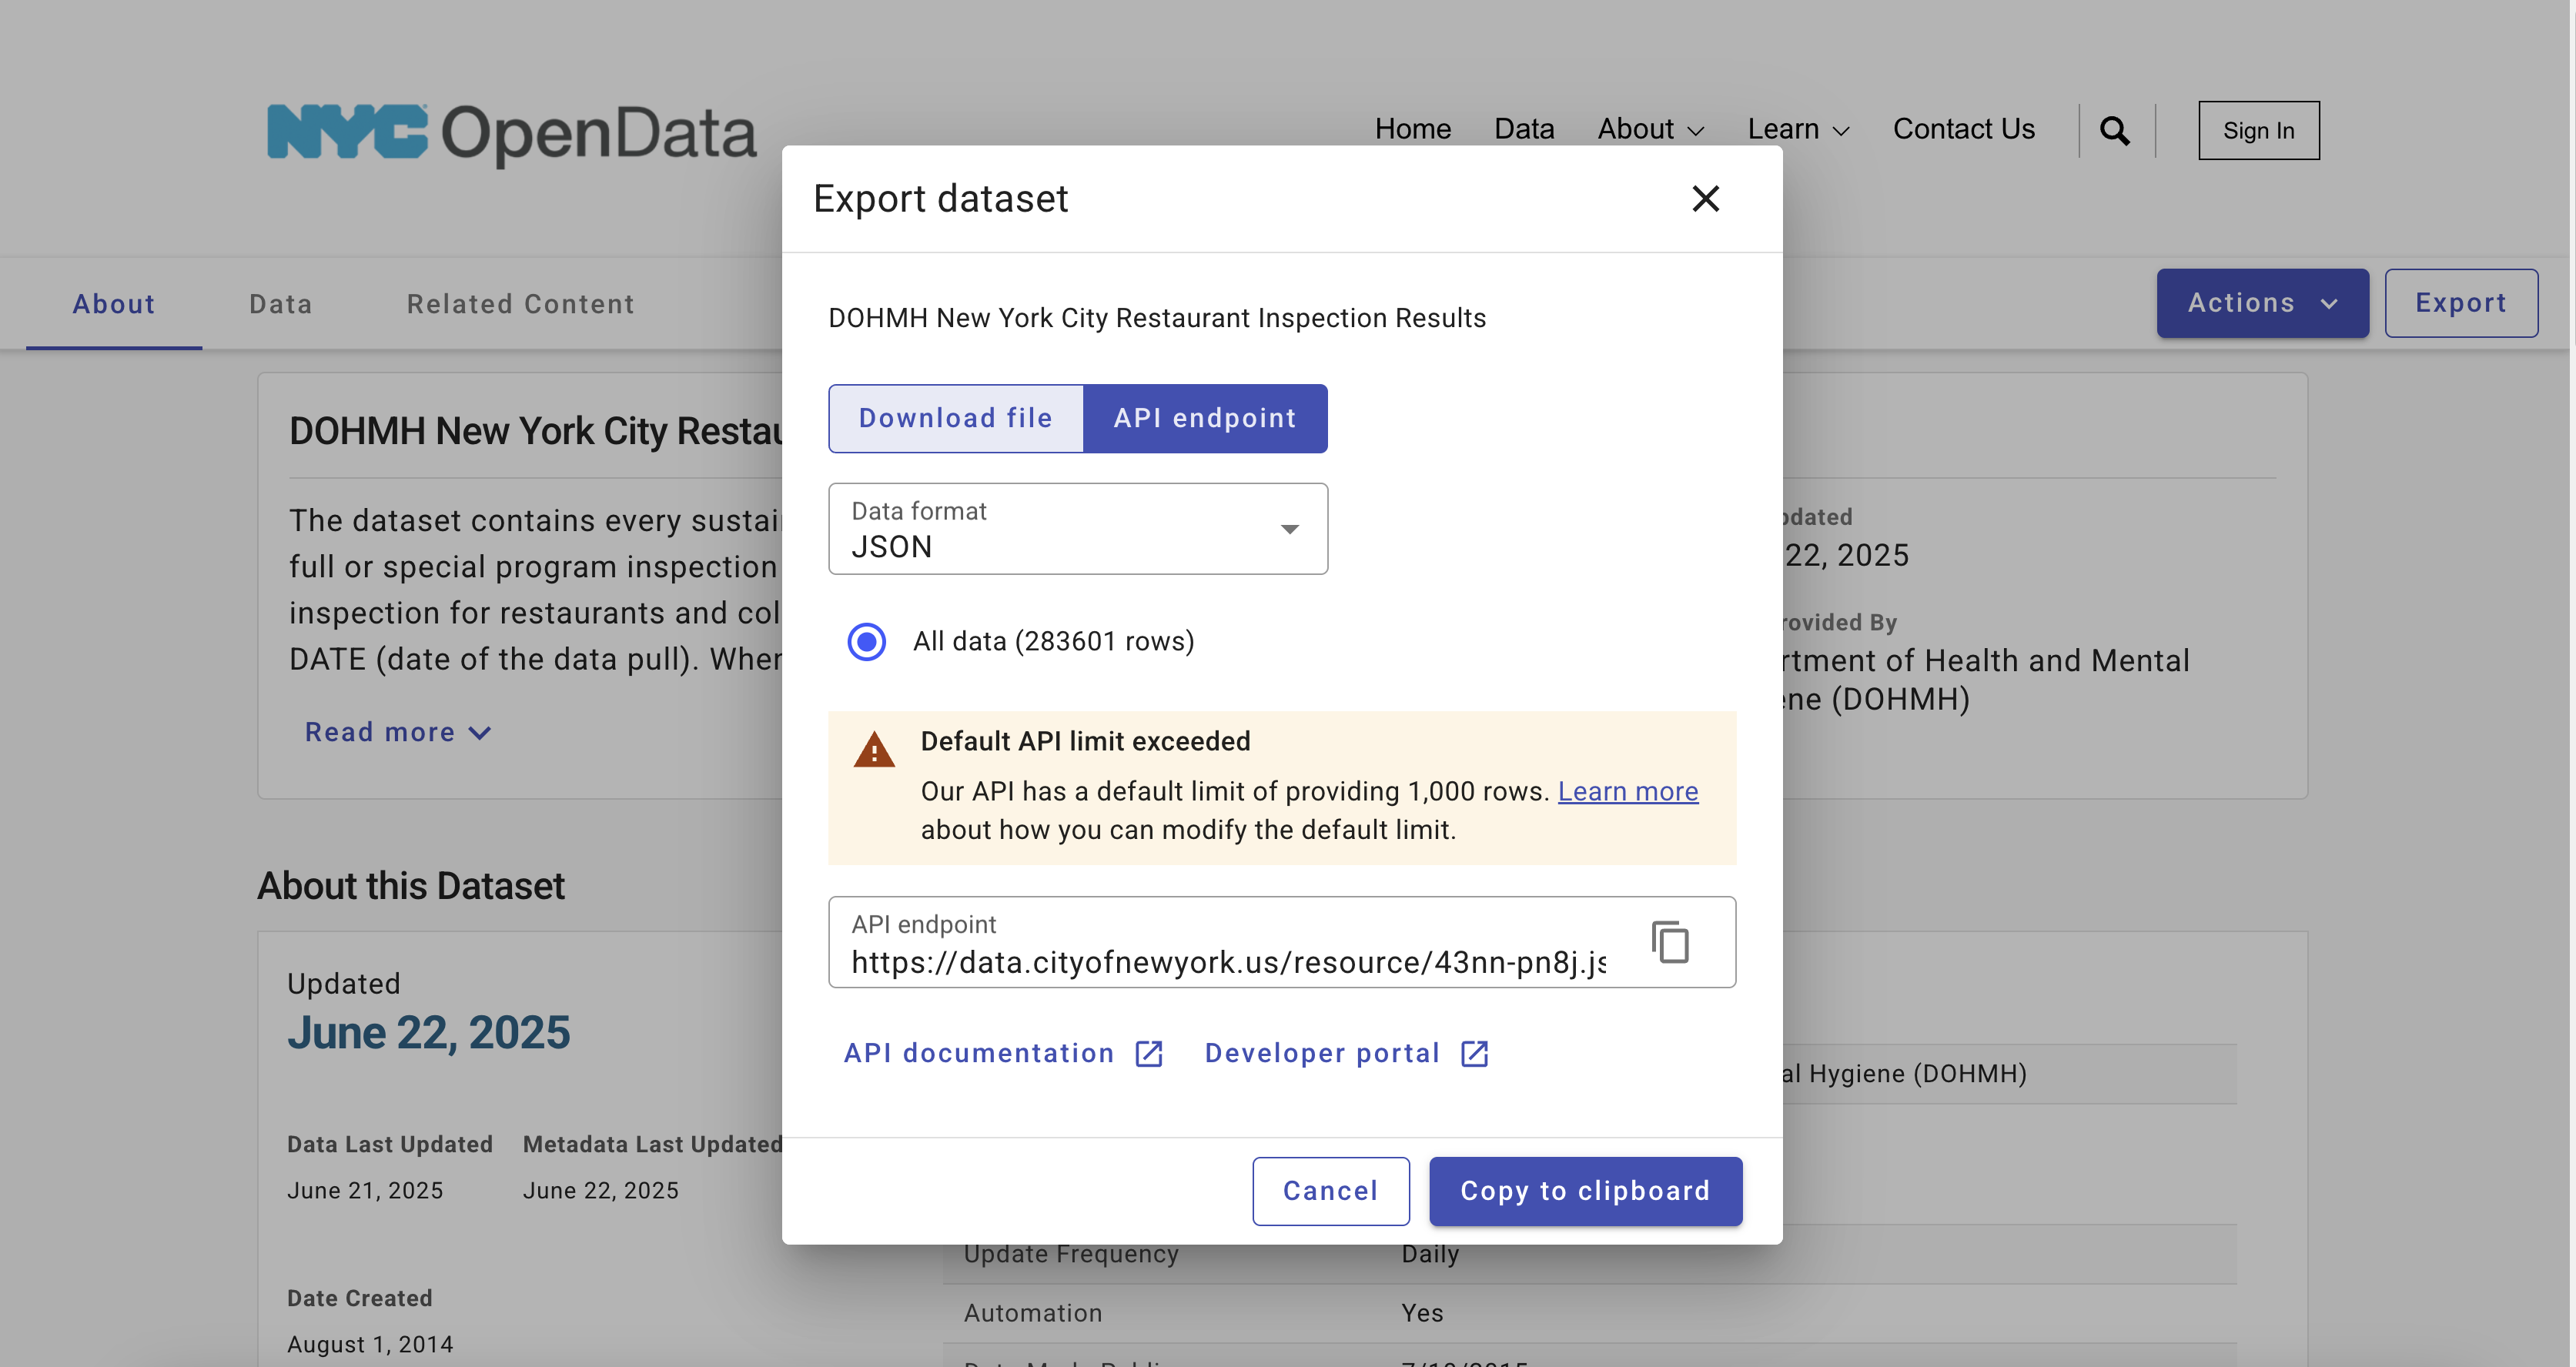

The API endpoint given there is the basis of the URL below. We are adding some additional query filters to focus the response items and reduce the total number of responses (as you can see in the screenshot above, there are over 280,000 results).

We add `?NTA=MN09&$limit=2000`, which signifies that we only want resulst where the `NTA` field equals `MN09` (i.e. Morningside Heights) and we `limit` the number of responses to `2000`. You can learn more about formatting SODA queries [here](https://dev.socrata.com/consumers/getting-started.html)

## get restaurants in Morningside Heights


If a query is successful, it will return a result that starts with `2**`, such as `200`. Error codes are reserved for `4**` and `5**`. We can make this most basic request first to confirm that our query is properly formatted:

In [8]:
requests.get(
    "https://data.cityofnewyork.us/resource/yjub-udmw.json"
)

<Response [200]>

What we really want, however, is the `json` associated with the response. We can create a new variable and set it to equal the response json payload:

In [17]:
wifi_data = requests.get(
    "https://data.cityofnewyork.us/resource/yjub-udmw.json"
).json()

If we print the results, we see we have an array of objects (up to 2000) that represents the restaurants in `MN09`. If you scan through, you'll see attributes like street, building number, cuisine_description, and restaurant scores. 

In [18]:
wifi_data

[{'objectid': '10604',
  'borough': '4',
  'type': 'Limited Free',
  'provider': 'SPECTRUM',
  'name': 'Baisley Pond Park',
  'location': 'Park Perimeter',
  'latitude': '40.67485999990',
  'longitude': '-73.78412000050',
  'x': '1044131.89696000000',
  'y': '185219.89207700000',
  'location_t': 'Outdoor TWC Aerial',
  'remarks': '3 free 10 min sessions',
  'city': 'Queens',
  'ssid': 'GuestWiFi',
  'sourceid': '0',
  'activated': '9999-09-09T00:00:00.000',
  'borocode': '4',
  'boroname': 'Queens',
  'ntacode': 'QN02',
  'ntaname': 'Springfield Gardens North',
  'coundist': '28.00000000000',
  'zip': '11434',
  'borocd': '412.00000000000',
  'ct2010': '294.00000000000',
  'bctcb2010': '294.00000000000',
  'bin': '0.00000000000',
  'bbl': '0.00000000000',
  'doitt_id': '1408',
  'location_lat_long': {'latitude': '40.6748599999',
   'longitude': '-73.7841200005'},
  ':@computed_region_efsh_h5xi': '24669',
  ':@computed_region_f5dn_yrer': '41',
  ':@computed_region_yeji_bk3q': '3',
  ':@

For these to be useful to us, let's cast the array as a geodataframe:

In [19]:
wifi_data = gpd.GeoDataFrame(
    wifi_data,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in wifi_data],
        [float(x["latitude"]) for x in wifi_data],
    ),
)

In [20]:
wifi_data.fillna("na", inplace=True)

Now we can see that we have a dataframe with a number of columns, including a geometry column, that we can use to perform calculations on.

In [21]:
wifi_data.columns

Index(['objectid', 'borough', 'type', 'provider', 'name', 'location',
       'latitude', 'longitude', 'x', 'y', 'location_t', 'remarks', 'city',
       'ssid', 'sourceid', 'activated', 'borocode', 'boroname', 'ntacode',
       'ntaname', 'coundist', 'zip', 'borocd', 'ct2010', 'bctcb2010', 'bin',
       'bbl', 'doitt_id', 'location_lat_long', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       'geometry'],
      dtype='object')

In [22]:
# Remove duplicates based on sourceid (most direct equivalent to camis)
wifi_data.drop_duplicates(subset="sourceid", inplace=True)

Let's inspect the doitt_id:

In [25]:
wifi_data.doitt_id.value_counts()

doitt_id
1408    1
1699    1
4920    1
3039    1
3035    1
       ..
3527    1
4798    1
4073    1
3554    1
3420    1
Name: count, Length: 562, dtype: int64

In [26]:
wifi_data.zip.value_counts()

zip
10025    36
10016    34
10019    24
10022    23
10011    23
         ..
11433     1
11210     1
11421     1
11222     1
10305     1
Name: count, Length: 82, dtype: int64

## Build a graph to allow us to search


Now that we have a geodataframe of restaurants, let's create a network based on the street grid of the neighborhood. To do so, we'll use the total geographic bounds of our restaurants dataframe to request a network from the `OSMnx` module. `OSMnx` is built on top of the `Networkx` library, and makes it easy for users to access information from `OpenStreetMap` for use in network analysis.

In [27]:
mh_bbox = wifi_data.total_bounds

In [ ]:
mh_bboxS

array([-74.115318  ,  40.564789  , -73.78412   ,  40.86732884])

Like the name implies, we can build a network graph from the bbox above using the `graph_from_bbox()` function. We can specify that we are interested in a `walk` type network (i.e. pedestrian paths and sidewalks) using the `network_type` parameter (vs `driving` or `all` for example).

Note too that the order of coordinates returned from the `total_bounds` property does not match the order that `OSMnx` expects it, so we have to reorder them via the `bbox` parameter.

In [32]:
# Even smaller - just a neighborhood around some hotspots
sample_hotspots = wifi_data.sample(50)  # Just 50 hotspots
small_bbox = [
    sample_hotspots['longitude'].min(),
    sample_hotspots['latitude'].min(),
    sample_hotspots['longitude'].max(), 
    sample_hotspots['latitude'].max()
]

small_network = ox.graph_from_bbox(
    bbox=[small_bbox[3], small_bbox[1], small_bbox[2], small_bbox[0]], 
    network_type="walk"
)

c:\Users\drmim\AppData\Local\Programs\Python\Python312\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 39,301 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


KeyboardInterrupt: 

We can confirm that the result is a `networkx` multidirectional (`MultiDiGraph`) graph object:

In [ ]:
mh_network

...and we can extract the nodes and edges of that network out as geodataframes:

converting wifi hotspots into network nodes.

In [ ]:
#mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

# Find nearest network nodes for each WiFi hotspot
print("Mapping WiFi hotspots to nearest street network nodes...")

wifi_nodes = []
for idx, hotspot in manhattan_wifi.iterrows():
    # Find nearest node in the street network
    nearest_node = ox.distance.nearest_nodes(
        mn_network, 
        hotspot['longitude'], 
        hotspot['latitude']
    )
    wifi_nodes.append({
        'hotspot_id': hotspot['objectid'],
        'network_node': nearest_node,
        'latitude': hotspot['latitude'],
        'longitude': hotspot['longitude'],
        'provider': hotspot['provider'],
        'location_type': hotspot['location_t']
    })

wifi_nodes_df = pd.DataFrame(wifi_nodes)
print(f"Mapped {len(wifi_nodes_df)} WiFi hotspots to network nodes")

calculating the distance between the wifi hotspots!

In [ ]:
# Calculate network distances between WiFi hotspots
print("Calculating network distances between WiFi hotspots...")

# Sample a subset for faster computation
sample_size = min(50, len(wifi_nodes_df))  # Start with 50 hotspots
sample_hotspots = wifi_nodes_df.sample(sample_size).reset_index(drop=True)

network_distances = []
euclidean_distances = []

for i in range(len(sample_hotspots)):
    for j in range(i+1, len(sample_hotspots)):
        node1 = sample_hotspots.loc[i, 'network_node']
        node2 = sample_hotspots.loc[j, 'network_node']
        
        try:
            # Network distance (shortest path)
            net_dist = nx.shortest_path_length(
                mn_network, node1, node2, weight='length'
            ) / 1000  # Convert to km
            
            # Euclidean distance
            lat1, lon1 = sample_hotspots.loc[i, 'latitude'], sample_hotspots.loc[i, 'longitude']
            lat2, lon2 = sample_hotspots.loc[j, 'latitude'], sample_hotspots.loc[j, 'longitude']
            
            euc_dist = ox.distance.great_circle_vec(lat1, lon1, lat2, lon2) / 1000  # Convert to km
            
            network_distances.append(net_dist)
            euclidean_distances.append(euc_dist)
            
        except nx.NetworkXNoPath:
            # No path exists between nodes
            continue

print(f"Calculated {len(network_distances)} distance pairs")

comparing distance types

In [ ]:
# Create comparison DataFrame
distance_comparison = pd.DataFrame({
    'euclidean_km': euclidean_distances,
    'network_km': network_distances
})

distance_comparison['ratio'] = distance_comparison['network_km'] / distance_comparison['euclidean_km']
distance_comparison['difference_km'] = distance_comparison['network_km'] - distance_comparison['euclidean_km']

# Summary statistics
print("\nDistance Comparison Summary:")
print(f"Average Euclidean distance: {distance_comparison['euclidean_km'].mean():.3f} km")
print(f"Average Network distance: {distance_comparison['network_km'].mean():.3f} km")
print(f"Average ratio (Network/Euclidean): {distance_comparison['ratio'].mean():.2f}")
print(f"Maximum ratio: {distance_comparison['ratio'].max():.2f}")

visualizing setup

In [ ]:
# Basic visualization of results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Euclidean vs Network distance
axes[0].scatter(distance_comparison['euclidean_km'], 
               distance_comparison['network_km'], 
               alpha=0.6, s=30)
axes[0].plot([0, distance_comparison['euclidean_km'].max()], 
            [0, distance_comparison['euclidean_km'].max()], 
            'r--', label='Perfect correlation')
axes[0].set_xlabel('Euclidean Distance (km)')
axes[0].set_ylabel('Network Distance (km)')
axes[0].set_title('Euclidean vs Network Distance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram of ratios
axes[1].hist(distance_comparison['ratio'], bins=20, alpha=0.7, edgecolor='black')
axes[1].axvline(distance_comparison['ratio'].mean(), color='red', 
               linestyle='--', label=f'Mean: {distance_comparison["ratio"].mean():.2f}')
axes[1].set_xlabel('Network/Euclidean Distance Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Distance Ratios')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

experimenting with claude for an interactive wifi network

In [ ]:
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_wifi_network_map(manhattan_wifi, mn_network, sample_hotspots):
    """Create interactive map showing WiFi hotspots and street network"""
    
    # Create base map centered on Manhattan
    center_lat = manhattan_wifi['latitude'].mean()
    center_lon = manhattan_wifi['longitude'].mean()
    
    m = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=12, 
        tiles='CartoDB positron'
    )
    
    # Add all WiFi hotspots colored by provider
    provider_colors = {
        'LinkNYC': 'blue',
        'Optimum WiFi': 'red', 
        'Spectrum': 'green',
        'Verizon': 'purple',
        'AT&T': 'orange'
    }
    
    for idx, hotspot in manhattan_wifi.iterrows():
        color = provider_colors.get(hotspot.get('provider', 'Unknown'), 'gray')
        
        folium.CircleMarker(
            location=[hotspot['latitude'], hotspot['longitude']],
            radius=4,
            popup=f"""
            <b>{hotspot.get('name', 'WiFi Hotspot')}</b><br>
            Provider: {hotspot.get('provider', 'Unknown')}<br>
            Type: {hotspot.get('location_t', 'Unknown')}<br>
            Borough: {hotspot.get('borough', 'Unknown')}
            """,
            color=color,
            fillColor=color,
            fillOpacity=0.7,
            weight=2
        ).add_to(m)
    
    # Highlight sample hotspots used in analysis
    for idx, hotspot in sample_hotspots.iterrows():
        folium.CircleMarker(
            location=[hotspot['latitude'], hotspot['longitude']],
            radius=8,
            popup=f"Analysis Node: {hotspot['hotspot_id']}",
            color='black',
            fillColor='yellow',
            fillOpacity=0.8,
            weight=3
        ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 160px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <b>WiFi Network Legend</b><br>
    <i style="color:blue">●</i> LinkNYC<br>
    <i style="color:red">●</i> Optimum WiFi<br>
    <i style="color:green">●</i> Spectrum<br>
    <i style="color:purple">●</i> Verizon<br>
    <i style="color:black; background:yellow">⬤</i> Analysis Sample<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create the map
wifi_map = create_wifi_network_map(manhattan_wifi, mn_network, sample_hotspots)
print("Interactive WiFi network map created!")

distance comparison charts

In [ ]:
def create_distance_analysis_charts(distance_comparison):
    """Create comprehensive distance comparison visualizations"""
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Euclidean vs Network Distance Comparison',
            'Distance Ratio Distribution', 
            'Distance Difference Analysis',
            'Cumulative Distance Distribution'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Scatter plot: Euclidean vs Network
    fig.add_trace(
        go.Scatter(
            x=distance_comparison['euclidean_km'],
            y=distance_comparison['network_km'],
            mode='markers',
            name='WiFi Pairs',
            marker=dict(size=6, opacity=0.7, color='blue'),
            text=[f'Ratio: {r:.2f}' for r in distance_comparison['ratio']],
            hovertemplate='Euclidean: %{x:.3f} km<br>Network: %{y:.3f} km<br>%{text}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Perfect correlation line
    max_dist = max(distance_comparison['euclidean_km'].max(), distance_comparison['network_km'].max())
    fig.add_trace(
        go.Scatter(
            x=[0, max_dist],
            y=[0, max_dist],
            mode='lines',
            name='Perfect Correlation',
            line=dict(dash='dash', color='red'),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. Ratio histogram
    fig.add_trace(
        go.Histogram(
            x=distance_comparison['ratio'],
            nbinsx=20,
            name='Ratio Distribution',
            marker_color='lightblue',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # 3. Difference analysis
    fig.add_trace(
        go.Scatter(
            x=distance_comparison['euclidean_km'],
            y=distance_comparison['difference_km'],
            mode='markers',
            name='Distance Difference',
            marker=dict(size=6, opacity=0.7, color='green'),
            hovertemplate='Euclidean: %{x:.3f} km<br>Difference: %{y:.3f} km<extra></extra>',
            showlegend=False
        ),
        row=2, col=1
    )
    
    # 4. Cumulative distributions
    euclidean_sorted = np.sort(distance_comparison['euclidean_km'])
    network_sorted = np.sort(distance_comparison['network_km'])
    y_cumulative = np.arange(1, len(euclidean_sorted) + 1) / len(euclidean_sorted)
    
    fig.add_trace(
        go.Scatter(
            x=euclidean_sorted,
            y=y_cumulative,
            mode='lines',
            name='Euclidean CDF',
            line=dict(color='blue')
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=network_sorted,
            y=y_cumulative,
            mode='lines',
            name='Network CDF',
            line=dict(color='red')
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="WiFi Hotspot Distance Analysis - Manhattan",
        showlegend=True
    )
    
    # Update axis labels
    fig.update_xaxes(title_text="Euclidean Distance (km)", row=1, col=1)
    fig.update_yaxes(title_text="Network Distance (km)", row=1, col=1)
    
    fig.update_xaxes(title_text="Network/Euclidean Ratio", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    
    fig.update_xaxes(title_text="Euclidean Distance (km)", row=2, col=1)
    fig.update_yaxes(title_text="Network - Euclidean (km)", row=2, col=1)
    
    fig.update_xaxes(title_text="Distance (km)", row=2, col=2)
    fig.update_yaxes(title_text="Cumulative Probability", row=2, col=2)
    
    return fig

# Create distance analysis charts
distance_charts = create_distance_analysis_charts(distance_comparison)
distance_charts.show()

using grid cells to build and traverse a network

In [ ]:
import h3
import geopandas as gpd
from shapely.geometry import Polygon, Point
import pandas as pd
from pysal.lib import weights
import networkx as nx

# First, convert your WiFi data to a GeoDataFrame
def create_wifi_geodataframe(manhattan_wifi):
    """Convert WiFi DataFrame to GeoDataFrame"""
    
    # Create geometry points from lat/lon
    geometry = [Point(lon, lat) for lon, lat in 
                zip(manhattan_wifi['longitude'], manhattan_wifi['latitude'])]
    
    wifi_gdf = gpd.GeoDataFrame(manhattan_wifi, geometry=geometry, crs="EPSG:4326")
    
    print(f"Created GeoDataFrame with {len(wifi_gdf)} WiFi hotspots")
    return wifi_gdf

# Create WiFi GeoDataFrame
wifi_gdf = create_wifi_geodataframe(manhattan_wifi)

# Use H3 grid to create hexagons around the WiFi hotspots
def assign_h3_hexagons(wifi_gdf, h3_resolution=9):
    """Assign H3 hexagon IDs to each WiFi hotspot"""
    
    print(f"Assigning H3 hexagons at resolution {h3_resolution}...")
    
    # Get H3 hexagon for each WiFi hotspot
    wifi_gdf["h3"] = wifi_gdf.apply(
        lambda x: h3.geo_to_h3(x.geometry.y, x.geometry.x, h3_resolution), 
        axis=1
    )
    
    print(f"Assigned {wifi_gdf['h3'].nunique()} unique hexagons")
    return wifi_gdf

# Assign hexagons to WiFi hotspots
wifi_gdf = assign_h3_hexagons(wifi_gdf, h3_resolution=9)

# Count WiFi hotspots in each hexagon
def count_wifi_per_hexagon(wifi_gdf):
    """Count WiFi hotspots in each hexagon and create summary stats"""
    
    hexagon_stats = wifi_gdf.groupby('h3').agg({
        'objectid': 'count',  # Count of hotspots
        'provider': lambda x: x.nunique(),  # Number of unique providers
        'location_t': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown',  # Most common location type
        'latitude': 'mean',   # Average coordinates for hexagon center
        'longitude': 'mean'
    }).reset_index()
    
    hexagon_stats.columns = ['h3', 'wifi_count', 'provider_diversity', 
                           'dominant_location_type', 'center_lat', 'center_lon']
    
    print("Hexagon statistics:")
    print(f"• Total hexagons: {len(hexagon_stats)}")
    print(f"• Max WiFi per hexagon: {hexagon_stats['wifi_count'].max()}")
    print(f"• Average WiFi per hexagon: {hexagon_stats['wifi_count'].mean():.1f}")
    
    return hexagon_stats

# Get hexagon statistics
hexagon_stats = count_wifi_per_hexagon(wifi_gdf)

# Create hexagon geometries
def create_hexagon_geometries(hexagon_stats):
    """Create actual hexagon geometries from H3 IDs"""
    
    print("Creating hexagon geometries...")
    
    # Get hexagon boundaries from H3
    hexagon_stats["geometry"] = hexagon_stats["h3"].apply(
        lambda x: h3.h3_to_geo_boundary(x)
    )
    
    # Convert H3 boundary format to Shapely Polygon
    # H3 returns (lat, lon) tuples, need to flip to (lon, lat) for Shapely
    hexagon_stats["geometry"] = hexagon_stats["geometry"].apply(
        lambda x: Polygon([(lon, lat) for lat, lon in x])
    )
    
    # Create GeoDataFrame
    hexagon_gdf = gpd.GeoDataFrame(hexagon_stats, geometry='geometry', crs="EPSG:4326")
    
    print(f"Created {len(hexagon_gdf)} hexagon geometries")
    return hexagon_gdf

# Create hexagon GeoDataFrame
hexagon_gdf = create_hexagon_geometries(hexagon_stats)

# Use PySAL to get adjacency between hexagons
def build_hexagon_adjacency(hexagon_gdf):
    """Build adjacency matrix for hexagons using PySAL"""
    
    print("Building hexagon adjacency matrix...")
    
    # Create spatial weights using Queen contiguity (shared edges/vertices)
    w = weights.Queen.from_dataframe(hexagon_gdf)
    
    print(f"Adjacency matrix created:")
    print(f"• {w.n} hexagons")
    print(f"• Average neighbors per hexagon: {w.mean_neighbors:.1f}")
    print(f"• Total connections: {w.s0/2:.0f}")  # Divide by 2 because symmetric
    
    return w

# Build adjacency
hexagon_weights = build_hexagon_adjacency(hexagon_gdf)

# Build NetworkX graph with hexagons as nodes
def build_hexagon_network(hexagon_gdf, hexagon_weights):
    """Build NetworkX graph from hexagon adjacency"""
    
    print("Building hexagon network graph...")
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with attributes
    for idx, row in hexagon_gdf.iterrows():
        G.add_node(
            row['h3'],
            wifi_count=row['wifi_count'],
            provider_diversity=row['provider_diversity'],
            dominant_location_type=row['dominant_location_type'],
            center_lat=row['center_lat'],
            center_lon=row['center_lon'],
            geometry=row['geometry']
        )
    
    # Add edges based on spatial adjacency
    for focal_idx, neighbors in hexagon_weights.neighbors.items():
        focal_h3 = hexagon_gdf.iloc[focal_idx]['h3']
        
        for neighbor_idx in neighbors:
            neighbor_h3 = hexagon_gdf.iloc[neighbor_idx]['h3']
            
            # Calculate edge weight based on combined WiFi density
            focal_wifi = hexagon_gdf.iloc[focal_idx]['wifi_count']
            neighbor_wifi = hexagon_gdf.iloc[neighbor_idx]['wifi_count']
            
            # Weight could be inverse of combined density (lower = better connectivity)
            # Or sum of densities (higher = more attractive path)
            edge_weight = focal_wifi + neighbor_wifi
            
            G.add_edge(focal_h3, neighbor_h3, weight=edge_weight)
    
    print(f"Hexagon network created:")
    print(f"• Nodes: {G.number_of_nodes()}")
    print(f"• Edges: {G.number_of_edges()}")
    print(f"• Connected: {nx.is_connected(G)}")
    
    return G

# Build the hexagon network
hexagon_network = build_hexagon_network(hexagon_gdf, hexagon_weights)

# Find shortest paths between high-density hexagons
def analyze_hexagon_paths(hexagon_network, hexagon_gdf):
    """Analyze shortest paths between important hexagons"""
    
    print("Analyzing paths between high-WiFi-density hexagons...")
    
    # Find hexagons with highest WiFi density
    top_hexagons = hexagon_gdf.nlargest(5, 'wifi_count')['h3'].tolist()
    
    print(f"Top 5 hexagons by WiFi count:")
    for h3_id in top_hexagons:
        wifi_count = hexagon_gdf[hexagon_gdf['h3'] == h3_id]['wifi_count'].iloc[0]
        print(f"  {h3_id}: {wifi_count} WiFi hotspots")
    
    # Calculate shortest paths between all pairs of top hexagons
    path_analysis = []
    
    for i, source in enumerate(top_hexagons):
        for target in top_hexagons[i+1:]:
            try:
                # Shortest path
                path = nx.shortest_path(hexagon_network, source, target, weight='weight')
                path_length = nx.shortest_path_length(hexagon_network, source, target, weight='weight')
                
                path_analysis.append({
                    'source': source,
                    'target': target,
                    'path_length': len(path),
                    'total_weight': path_length,
                    'path': path
                })
                
            except nx.NetworkXNoPath:
                print(f"No path between {source} and {target}")
    
    return path_analysis, top_hexagons

# Analyze paths
path_analysis, top_hexagons = analyze_hexagon_paths(hexagon_network, hexagon_gdf)

# Visualize the hexagon network
def visualize_hexagon_network(hexagon_gdf, wifi_gdf, path_analysis):
    """Create visualizations of the hexagon network"""
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot 1: Hexagons colored by WiFi density
    hexagon_gdf.plot(
        column='wifi_count',
        cmap='YlOrRd',
        legend=True,
        ax=axes[0],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )
    
    # Add WiFi points
    wifi_gdf.plot(
        ax=axes[0],
        color='blue',
        markersize=2,
        alpha=0.6
    )
    
    axes[0].set_title('H3 Hexagons by WiFi Density\n(with original WiFi hotspots)')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    
    # Plot 2: Network connections
    hexagon_gdf.boundary.plot(ax=axes[1], color='gray', linewidth=0.5)
    
    # Highlight top hexagons
    top_hexagon_gdf = hexagon_gdf[hexagon_gdf['h3'].isin(top_hexagons)]
    top_hexagon_gdf.plot(
        ax=axes[1],
        color='red',
        alpha=0.7,
        edgecolor='black',
        linewidth=2
    )
    
    # Draw shortest paths
    if path_analysis:
        for path_info in path_analysis[:3]:  # Show first 3 paths to avoid clutter
            path_coords = []
            for h3_id in path_info['path']:
                row = hexagon_gdf[hexagon_gdf['h3'] == h3_id].iloc[0]
                path_coords.append([row['center_lon'], row['center_lat']])
            
            if len(path_coords) > 1:
                xs, ys = zip(*path_coords)
                axes[1].plot(xs, ys, 'b-', linewidth=3, alpha=0.7)
    
    axes[1].set_title('Hexagon Network with Shortest Paths\n(Red = High WiFi Density)')
    axes[1].set_xlabel('Longitude') 
    axes[1].set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_hexagon_network(hexagon_gdf, wifi_gdf, path_analysis)

# Summary results
print("\n" + "="*60)
print("HEXAGON NETWORK ANALYSIS RESULTS")
print("="*60)

print(f"Grid Analysis Summary:")
print(f"• H3 Resolution: 9 (hexagon side ~50m)")
print(f"• Total hexagons covering Manhattan WiFi: {len(hexagon_gdf)}")
print(f"• Average WiFi hotspots per hexagon: {hexagon_gdf['wifi_count'].mean():.1f}")
print(f"• Hexagons with no WiFi: {(hexagon_gdf['wifi_count'] == 0).sum()}")
print(f"• Most WiFi in one hexagon: {hexagon_gdf['wifi_count'].max()}")

if path_analysis:
    print(f"\nPath Analysis:")
    avg_path_length = sum(p['path_length'] for p in path_analysis) / len(path_analysis)
    print(f"• Average path length between top hexagons: {avg_path_length:.1f} hops")
    print(f"• Longest path: {max(p['path_length'] for p in path_analysis)} hops")
    print(f"• Total path pairs analyzed: {len(path_analysis)}")

print(f"\nThis hexagonal grid approach reveals spatial clustering patterns")
print(f"and provides a different perspective on WiFi network connectivity!")